# Tile Coding
---

Tile coding is an innovative way of discretizing a continuous space that enables better generalization compared to a single grid-based approach. The fundamental idea is to create several overlapping grids or _tilings_; then for any given sample value, you need only check which tiles it lies in. You can then encode the original continuous value by a vector of integer indices or bits that identifies each activated tile.

### 1. Import the Necessary Packages

In [77]:
# Import common libraries
import sys
import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import pickle5 as pickle
# Set plotting options
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

### 2. Specify the Environment, and Explore the State and Action Spaces

We'll use [OpenAI Gym](https://gym.openai.com/) environments to test and develop our algorithms. These simulate a variety of classic as well as contemporary reinforcement learning tasks.  Let's begin with an environment that has a continuous state space, but a discrete action space.

In [60]:
# Create an environment
env = gym.make('Acrobot-v1').env

env.seed(505);

# Explore state (observation) space
print("State space:", env.observation_space)
print("- low:", env.observation_space.low)
print("- high:", env.observation_space.high)

# Explore action space
print("Action space:", env.action_space)

State space: Box(-28.274333953857422, 28.274333953857422, (6,), float32)
- low: [ -1.     -1.     -1.     -1.    -12.566 -28.274]
- high: [ 1.     1.     1.     1.    12.566 28.274]
Action space: Discrete(3)


Note that the state space is multi-dimensional, with most dimensions ranging from -1 to 1 (positions of the two joints), while the final two dimensions have a larger range. How do we discretize such a space using tiles?

### 3. Tiling

Let's first design a way to create a single tiling for a given state space. This is very similar to a uniform grid! The only difference is that you should include an offset for each dimension that shifts the split points.

For instance, if `low = [-1.0, -5.0]`, `high = [1.0, 5.0]`, `bins = (10, 10)`, and `offsets = (-0.1, 0.5)`, then return a list of 2 NumPy arrays (2 dimensions) each containing the following split points (9 split points per dimension):

```
[array([-0.9, -0.7, -0.5, -0.3, -0.1,  0.1,  0.3,  0.5,  0.7]),
 array([-3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5])]
```

Notice how the split points for the first dimension are offset by `-0.1`, and for the second dimension are offset by `+0.5`. This might mean that some of our tiles, especially along the perimeter, are partially outside the valid state space, but that is unavoidable and harmless.

In [61]:
def create_tiling_grid(low, high, bins=(10, 10), offsets=(0.0, 0.0)):
    """Define a uniformly-spaced grid that can be used for tile-coding a space.
    
    Parameters
    ----------
    low : array_like
        Lower bounds for each dimension of the continuous space.
    high : array_like
        Upper bounds for each dimension of the continuous space.
    bins : tuple
        Number of bins or tiles along each corresponding dimension.
    offsets : tuple
        Split points for each dimension should be offset by these values.
    
    Returns
    -------
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    """
    # TODO: Implement this
    grid = [np.linspace(low[dim], high[dim], bins[dim] + 1)[1:-1] + offsets[dim] for dim in range(len(bins))]
    print("Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>")
    for l, h, b, o, splits in zip(low, high, bins, offsets, grid):
        print("    [{}, {}] / {} + ({}) => {}".format(l, h, b, o, splits))
    return grid


low = [-1.0, -5.0]
high = [1.0, 5.0]
create_tiling_grid(low, high, bins=(10, 10), offsets=(-0.1, 0.5))  # [test]

Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (-0.1) => [-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7]
    [-5.0, 5.0] / 10 + (0.5) => [-3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5  4.5]


[array([-0.9, -0.7, -0.5, -0.3, -0.1,  0.1,  0.3,  0.5,  0.7]),
 array([-3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5])]

You can now use this function to define a set of tilings that are a little offset from each other.

In [62]:
def create_tilings(low, high, tiling_specs):
    """Define multiple tilings using the provided specifications.

    Parameters
    ----------
    low : array_like
        Lower bounds for each dimension of the continuous space.
    high : array_like
        Upper bounds for each dimension of the continuous space.
    tiling_specs : list of tuples
        A sequence of (bins, offsets) to be passed to create_tiling_grid().

    Returns
    -------
    tilings : list
        A list of tilings (grids), each produced by create_tiling_grid().
    """
    # TODO: Implement this
    return [create_tiling_grid(low, high, bins, offsets) for bins, offsets in tiling_specs]


# Tiling specs: [(<bins>, <offsets>), ...]
tiling_specs = [((10, 10), (-0.066, -0.33)),
                ((10, 10), (0.0, 0.0)),
                ((10, 10), (0.066, 0.33))]
tilings = create_tilings(low, high, tiling_specs)

Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (-0.066) => [-0.866 -0.666 -0.466 -0.266 -0.066  0.134  0.334  0.534  0.734]
    [-5.0, 5.0] / 10 + (-0.33) => [-4.33 -3.33 -2.33 -1.33 -0.33  0.67  1.67  2.67  3.67]
Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (0.0) => [-0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8]
    [-5.0, 5.0] / 10 + (0.0) => [-4. -3. -2. -1.  0.  1.  2.  3.  4.]
Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (0.066) => [-0.734 -0.534 -0.334 -0.134  0.066  0.266  0.466  0.666  0.866]
    [-5.0, 5.0] / 10 + (0.33) => [-3.67 -2.67 -1.67 -0.67  0.33  1.33  2.33  3.33  4.33]


It may be hard to gauge whether you are getting desired results or not. So let's try to visualize these tilings.

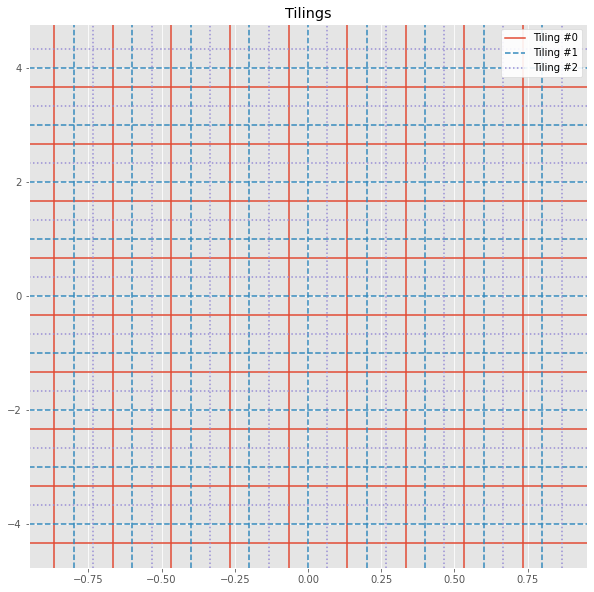

In [63]:
from matplotlib.lines import Line2D

def visualize_tilings(tilings):
    """Plot each tiling as a grid."""
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    linestyles = ['-', '--', ':']
    legend_lines = []

    fig, ax = plt.subplots(figsize=(10, 10))
    for i, grid in enumerate(tilings):
        for x in grid[0]:
            l = ax.axvline(x=x, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)], label=i)
        for y in grid[1]:
            l = ax.axhline(y=y, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)])
        legend_lines.append(l)
    ax.grid('off')
    ax.legend(legend_lines, ["Tiling #{}".format(t) for t in range(len(legend_lines))], facecolor='white', framealpha=0.9)
    ax.set_title("Tilings")
    return ax  # return Axis object to draw on later, if needed


visualize_tilings(tilings);

Great! Now that we have a way to generate these tilings, we can next write our encoding function that will convert any given continuous state value to a discrete vector.

### 4. Tile Encoding

Implement the following to produce a vector that contains the indices for each tile that the input state value belongs to. The shape of the vector can be the same as the arrangment of tiles you have, or it can be ultimately flattened for convenience.

You can use the same `discretize()` function here from grid-based discretization, and simply call it for each tiling.

In [64]:
def discretize(sample, grid):
    """Discretize a sample as per given grid.
    
    Parameters
    ----------
    sample : array_like
        A single sample from the (original) continuous space.
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    
    Returns
    -------
    discretized_sample : array_like
        A sequence of integers with the same number of dimensions as sample.
    """
    # TODO: Implement this
    return tuple(int(np.digitize(s, g)) for s, g in zip(sample, grid))  # apply along each dimension


def tile_encode(sample, tilings, flatten=False):
    """Encode given sample using tile-coding.
    
    Parameters
    ----------
    sample : array_like
        A single sample from the (original) continuous space.
    tilings : list
        A list of tilings (grids), each produced by create_tiling_grid().
    flatten : bool
        If true, flatten the resulting binary arrays into a single long vector.

    Returns
    -------
    encoded_sample : list or array_like
        A list of binary vectors, one for each tiling, or flattened into one.
    """
    # TODO: Implement this
    encoded_sample = [discretize(sample, grid) for grid in tilings]
    return np.concatenate(encoded_sample) if flatten else encoded_sample


# Test with some sample values
samples = [(-1.2 , -5.1 ),
           (-0.75,  3.25),
           (-0.5 ,  0.0 ),
           ( 0.25, -1.9 ),
           ( 0.15, -1.75),
           ( 0.75,  2.5 ),
           ( 0.7 , -3.7 ),
           ( 1.0 ,  5.0 )]
encoded_samples = [tile_encode(sample, tilings) for sample in samples]
print("\nSamples:", repr(samples), sep="\n")
print("\nEncoded samples:", repr(encoded_samples), sep="\n")


Samples:
[(-1.2, -5.1), (-0.75, 3.25), (-0.5, 0.0), (0.25, -1.9), (0.15, -1.75), (0.75, 2.5), (0.7, -3.7), (1.0, 5.0)]

Encoded samples:
[[(0, 0), (0, 0), (0, 0)], [(1, 8), (1, 8), (0, 7)], [(2, 5), (2, 5), (2, 4)], [(6, 3), (6, 3), (5, 2)], [(6, 3), (5, 3), (5, 2)], [(9, 7), (8, 7), (8, 7)], [(8, 1), (8, 1), (8, 0)], [(9, 9), (9, 9), (9, 9)]]


Note that we did not flatten the encoding above, which is why each sample's representation is a pair of indices for each tiling. This makes it easy to visualize it using the tilings.

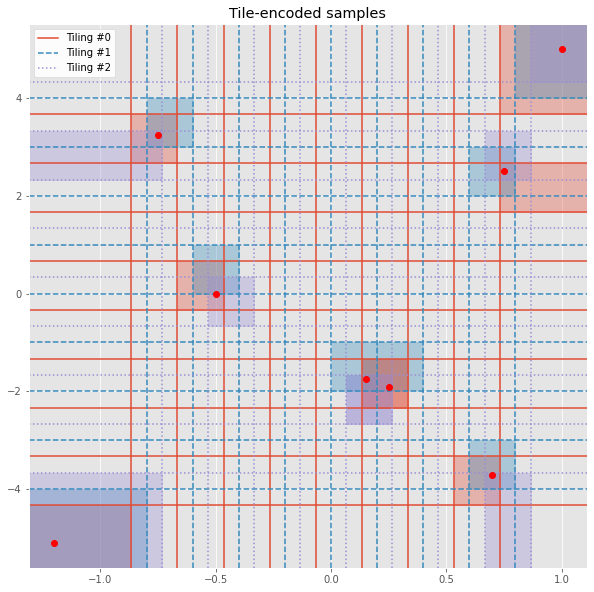

In [65]:
from matplotlib.patches import Rectangle

def visualize_encoded_samples(samples, encoded_samples, tilings, low=None, high=None):
    """Visualize samples by activating the respective tiles."""
    samples = np.array(samples)  # for ease of indexing

    # Show tiling grids
    ax = visualize_tilings(tilings)
    
    # If bounds (low, high) are specified, use them to set axis limits
    if low is not None and high is not None:
        ax.set_xlim(low[0], high[0])
        ax.set_ylim(low[1], high[1])
    else:
        # Pre-render (invisible) samples to automatically set reasonable axis limits, and use them as (low, high)
        ax.plot(samples[:, 0], samples[:, 1], 'o', alpha=0.0)
        low = [ax.get_xlim()[0], ax.get_ylim()[0]]
        high = [ax.get_xlim()[1], ax.get_ylim()[1]]

    # Map each encoded sample (which is really a list of indices) to the corresponding tiles it belongs to
    tilings_extended = [np.hstack((np.array([low]).T, grid, np.array([high]).T)) for grid in tilings]  # add low and high ends
    tile_centers = [(grid_extended[:, 1:] + grid_extended[:, :-1]) / 2 for grid_extended in tilings_extended]  # compute center of each tile
    tile_toplefts = [grid_extended[:, :-1] for grid_extended in tilings_extended]  # compute topleft of each tile
    tile_bottomrights = [grid_extended[:, 1:] for grid_extended in tilings_extended]  # compute bottomright of each tile

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    for sample, encoded_sample in zip(samples, encoded_samples):
        for i, tile in enumerate(encoded_sample):
            # Shade the entire tile with a rectangle
            topleft = tile_toplefts[i][0][tile[0]], tile_toplefts[i][1][tile[1]]
            bottomright = tile_bottomrights[i][0][tile[0]], tile_bottomrights[i][1][tile[1]]
            ax.add_patch(Rectangle(topleft, bottomright[0] - topleft[0], bottomright[1] - topleft[1],
                                   color=colors[i], alpha=0.33))

            # In case sample is outside tile bounds, it may not have been highlighted properly
            if any(sample < topleft) or any(sample > bottomright):
                # So plot a point in the center of the tile and draw a connecting line
                cx, cy = tile_centers[i][0][tile[0]], tile_centers[i][1][tile[1]]
                ax.add_line(Line2D([sample[0], cx], [sample[1], cy], color=colors[i]))
                ax.plot(cx, cy, 's', color=colors[i])
    
    # Finally, plot original samples
    ax.plot(samples[:, 0], samples[:, 1], 'o', color='r')

    ax.margins(x=0, y=0)  # remove unnecessary margins
    ax.set_title("Tile-encoded samples")
    return ax

visualize_encoded_samples(samples, encoded_samples, tilings);

Inspect the results and make sure you understand how the corresponding tiles are being chosen. Note that some samples may have one or more tiles in common.

### 5. Q-Table with Tile Coding

The next step is to design a special Q-table that is able to utilize this tile coding scheme. It should have the same kind of interface as a regular table, i.e. given a `<state, action>` pair, it should return a `<value>`. Similarly, it should also allow you to update the `<value>` for a given `<state, action>` pair (note that this should update all the tiles that `<state>` belongs to).

The `<state>` supplied here is assumed to be from the original continuous state space, and `<action>` is discrete (and integer index). The Q-table should internally convert the `<state>` to its tile-coded representation when required.

In [66]:
class QTable:
    """Simple Q-table."""

    def __init__(self, state_size, action_size):
        """Initialize Q-table.
        
        Parameters
        ----------
        state_size : tuple
            Number of discrete values along each dimension of state space.
        action_size : int
            Number of discrete actions in action space.
        """
        self.state_size = state_size
        self.action_size = action_size

        # TODO: Create Q-table, initialize all Q-values to zero
        # Note: If state_size = (9, 9), action_size = 2, q_table.shape should be (9, 9, 2)
        self.q_table = np.zeros(shape=(self.state_size + (self.action_size,)))
        print("QTable(): size =", self.q_table.shape)


class TiledQTable:
    """Composite Q-table with an internal tile coding scheme."""
    
    def __init__(self, low, high, tiling_specs, action_size):
        """Create tilings and initialize internal Q-table(s).
        
        Parameters
        ----------
        low : array_like
            Lower bounds for each dimension of state space.
        high : array_like
            Upper bounds for each dimension of state space.
        tiling_specs : list of tuples
            A sequence of (bins, offsets) to be passed to create_tilings() along with low, high.
        action_size : int
            Number of discrete actions in action space.
        """
        self.tilings = create_tilings(low, high, tiling_specs)
        self.state_sizes = [tuple(len(splits)+1 for splits in tiling_grid) for tiling_grid in self.tilings]
        self.action_size = action_size
        self.q_tables = [QTable(state_size, self.action_size) for state_size in self.state_sizes]
        print("TiledQTable(): no. of internal tables = ", len(self.q_tables))
    
    def get(self, state, action):
        """Get Q-value for given <state, action> pair.
        
        Parameters
        ----------
        state : array_like
            Vector representing the state in the original continuous space.
        action : int
            Index of desired action.
        
        Returns
        -------
        value : float
            Q-value of given <state, action> pair, averaged from all internal Q-tables.
        """
        # TODO: Encode state to get tile indices
        encoded_state = tile_encode(state, self.tilings)
        
        # TODO: Retrieve q-value for each tiling, and return their average
        value = 0.0
        for idx, q_table in zip(encoded_state, self.q_tables):
            value += q_table.q_table[tuple(idx + (action,))]
        value /= len(self.q_tables)
        return value
    
    def update(self, state, action, value, alpha=0.1):
        """Soft-update Q-value for given <state, action> pair to value.
        
        Instead of overwriting Q(state, action) with value, perform soft-update:
            Q(state, action) = alpha * value + (1.0 - alpha) * Q(state, action)
        
        Parameters
        ----------
        state : array_like
            Vector representing the state in the original continuous space.
        action : int
            Index of desired action.
        value : float
            Desired Q-value for <state, action> pair.
        alpha : float
            Update factor to perform soft-update, in [0.0, 1.0] range.
        """
        # TODO: Encode state to get tile indices
        encoded_state = tile_encode(state, self.tilings)
        
        # TODO: Update q-value for each tiling by update factor alpha
        for idx, q_table in zip(encoded_state, self.q_tables):
            value_ = q_table.q_table[tuple(idx + (action,))]  # current value
            q_table.q_table[tuple(idx + (action,))] = alpha * value + (1.0 - alpha) * value_


# Test with a sample Q-table
tq = TiledQTable(low, high, tiling_specs, 2)
s1 = 3; s2 = 4; a = 0; q = 1.0
print("[GET]    Q({}, {}) = {}".format(samples[s1], a, tq.get(samples[s1], a)))  # check value at sample = s1, action = a
print("[UPDATE] Q({}, {}) = {}".format(samples[s2], a, q)); tq.update(samples[s2], a, q)  # update value for sample with some common tile(s)
print("[GET]    Q({}, {}) = {}".format(samples[s1], a, tq.get(samples[s1], a)))  # check value again, should be slightly updated

Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (-0.066) => [-0.866 -0.666 -0.466 -0.266 -0.066  0.134  0.334  0.534  0.734]
    [-5.0, 5.0] / 10 + (-0.33) => [-4.33 -3.33 -2.33 -1.33 -0.33  0.67  1.67  2.67  3.67]
Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (0.0) => [-0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8]
    [-5.0, 5.0] / 10 + (0.0) => [-4. -3. -2. -1.  0.  1.  2.  3.  4.]
Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (0.066) => [-0.734 -0.534 -0.334 -0.134  0.066  0.266  0.466  0.666  0.866]
    [-5.0, 5.0] / 10 + (0.33) => [-3.67 -2.67 -1.67 -0.67  0.33  1.33  2.33  3.33  4.33]
QTable(): size = (10, 10, 2)
QTable(): size = (10, 10, 2)
QTable(): size = (10, 10, 2)
TiledQTable(): no. of internal tables =  3
[GET]    Q((0.25, -1.9), 0) = 0.0
[UPDATE] Q((0.15, -1.75), 0) = 1.0
[GET]    Q((0.25, -1.9), 0) = 0.06666666666666667


If you update the q-value for a particular state (say, `(0.25, -1.91)`) and action (say, `0`), then you should notice the q-value of a nearby state (e.g. `(0.15, -1.75)` and same action) has changed as well! This is how tile-coding is able to generalize values across the state space better than a single uniform grid.

### 6. Implement a Sarsa Agent using Tile-Coding

Now it's your turn to apply this discretization technique to design and test a complete learning agent! 

In [67]:
class SarsaAgent:
    """Sarsa agent that can act on a continuous state space by discretizing it."""

    def __init__(self, env, tq, alpha=0.02, gamma=0.55,
                 epsilon=1.0, epsilon_decay_rate=0.9995, min_epsilon=.01, seed=0):
        """Initialize variables, create grid for discretization."""
        # Environment info
        self.env = env
        self.tq = tq 
        self.state_sizes = tq.state_sizes           # list of state sizes for each tiling
        self.action_size = self.env.action_space.n  # 1-dimensional discrete action space
        self.seed = np.random.seed(seed)
        print("Environment:", self.env)
        print("State space sizes:", self.state_sizes)
        print("Action space size:", self.action_size)
        
        # Learning parameters
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = self.initial_epsilon = epsilon  # initial exploration rate
        self.epsilon_decay_rate = epsilon_decay_rate   # how quickly should we decrease epsilon
        self.min_epsilon = min_epsilon

    def reset_episode(self, state):
        """Reset variables for a new episode."""
        # Gradually decrease exploration rate
        self.epsilon *= self.epsilon_decay_rate
        self.epsilon = max(self.epsilon, self.min_epsilon)
        
        self.last_state = state
        Q_s = [self.tq.get(state, action) for action in range(self.action_size)]
        self.last_action = np.argmax(Q_s)
        return self.last_action
    
    def reset_exploration(self, epsilon=None):
        """Reset exploration rate used when training."""
        self.epsilon = epsilon if epsilon is not None else self.initial_epsilon

    def act(self, state, reward=None, done=None, mode='train'):
        """Pick next action and update internal Q table (when mode != 'test')."""
        Q_s = [self.tq.get(state, action) for action in range(self.action_size)]
        # Pick the best action from Q table
        greedy_action = np.argmax(Q_s)
        if mode == 'test':
            # Test mode: Simply produce an action
            action = greedy_action
        else:
            # Train mode (default): Update Q table, pick next action
            # Note: We update the Q table entry for the *last* (state, action) pair with current state, reward


            # Exploration vs. exploitation
            do_exploration = np.random.uniform(0, 1) < self.epsilon
            if do_exploration:
                # Pick a random action
                action = np.random.randint(0, self.action_size)
            else:
                # Pick the greedy action
                action = greedy_action
            value = reward + self.gamma * Q_s[action]
            self.tq.update(self.last_state, self.last_action, value, self.alpha)

        # Roll over current state, action for next step
        self.last_state = state
        self.last_action = action
        return action

In [68]:
n_bins = 5
bins = tuple([n_bins]*env.observation_space.shape[0])
offset_pos = (env.observation_space.high - env.observation_space.low)/(3*n_bins)

# env._max_episode_steps = 5000


tiling_specs = [(bins, -offset_pos),
                (bins, tuple([0.0]*env.observation_space.shape[0])),
                (bins, offset_pos)]

tq = TiledQTable(env.observation_space.low, 
                 env.observation_space.high, 
                 tiling_specs, 
                 env.action_space.n)
agent = SarsaAgent(env, tq)

Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 5 + (-0.13333334028720856) => [-0.733 -0.333  0.067  0.467]
    [-1.0, 1.0] / 5 + (-0.13333334028720856) => [-0.733 -0.333  0.067  0.467]
    [-1.0, 1.0] / 5 + (-0.13333334028720856) => [-0.733 -0.333  0.067  0.467]
    [-1.0, 1.0] / 5 + (-0.13333334028720856) => [-0.733 -0.333  0.067  0.467]
    [-12.566370964050293, 12.566370964050293] / 5 + (-1.675516128540039) => [-9.215 -4.189  0.838  5.864]
    [-28.274333953857422, 28.274333953857422] / 5 + (-3.769911289215088) => [-20.735  -9.425   1.885  13.195]
Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 5 + (0.0) => [-0.6 -0.2  0.2  0.6]
    [-1.0, 1.0] / 5 + (0.0) => [-0.6 -0.2  0.2  0.6]
    [-1.0, 1.0] / 5 + (0.0) => [-0.6 -0.2  0.2  0.6]
    [-1.0, 1.0] / 5 + (0.0) => [-0.6 -0.2  0.2  0.6]
    [-12.566370964050293, 12.566370964050293] / 5 + (0.0) => [-7.54  -2.513  2.513  7.54 ]
    [-28.274333953857422, 28.274333953857422] / 5 + (

In [69]:
def run(agent, env, num_episodes=10000, mode='train'):
    """Run agent in given reinforcement learning environment and return scores."""
    scores = []
    max_avg_score = -np.inf
    for i_episode in range(1, num_episodes+1):
        # Initialize episode
        state = env.reset()
        action = agent.reset_episode(state)
        total_reward = 0
        done = False
        count = 0
        # Roll out steps until done
        while not done:
            count = count + 1
            state, reward, done, info = env.step(action)
            total_reward += reward
            action = agent.act(state, reward, done, mode)
        print(i_episode,count)
        # Save final score
        scores.append(total_reward)

        # Print episode stats
        if mode == 'train':
            if len(scores) > 100:
                avg_score = np.mean(scores[-100:])
                if avg_score > max_avg_score:
                    max_avg_score = avg_score
            if i_episode % 100 == 0:
                print("\rEpisode {}/{} | Max Average Score: {}".format(i_episode, num_episodes, max_avg_score), end="")
                sys.stdout.flush()
    return scores

scores = run(agent, env)

1 1210
2 891
3 1907
4 2086
5 839
6 1102
7 1178
8 1289
9 2929
10 2751
11 1424
12 583
13 1813
14 3004
15 634
16 1442
17 488
18 2504
19 1157
20 1069
21 2627
22 495
23 1042
24 1654
25 1937
26 1085
27 1415
28 1034
29 2294
30 906
31 848
32 2701
33 1924
34 4101
35 3850
36 3934
37 1695
38 529
39 1679
40 1141
41 1618
42 1124
43 1878
44 2470
45 2438
46 2767
47 1044
48 1018
49 1323
50 2781
51 2715
52 5451
53 1086
54 1556
55 2485
56 3120
57 728
58 5255
59 431
60 1023
61 1565
62 4179
63 2854
64 1611
65 397
66 5508
67 974
68 5853
69 3138
70 764
71 2516
72 1004
73 1022
74 912
75 1072
76 2247
77 1900
78 2016
79 3144
80 2522
81 1542
82 963
83 856
84 1766
85 752
86 1346
87 1101
88 2459
89 5507
90 676
91 476
92 2099
93 1108
94 2492
95 679
96 2545
97 1078
98 2949
99 1097
100 1141
Episode 100/10000 | Max Average Score: -inf101 1452
102 1572
103 724
104 646
105 2169
106 2146
107 445
108 599
109 819
110 586
111 1091
112 871
113 1015
114 1354
115 1226
116 700
117 1564
118 1791
119 4357
120 1946
121 1132
122 7

956 299
957 264
958 724
959 461
960 624
961 423
962 604
963 361
964 281
965 457
966 257
967 715
968 487
969 1126
970 614
971 801
972 512
973 323
974 439
975 431
976 407
977 282
978 484
979 347
980 753
981 353
982 421
983 428
984 449
985 332
986 781
987 707
988 545
989 461
990 715
991 461
992 289
993 340
994 249
995 592
996 451
997 458
998 389
999 310
1000 842
Episode 1000/10000 | Max Average Score: -513.51001 281
1002 388
1003 596
1004 347
1005 584
1006 580
1007 366
1008 504
1009 190
1010 256
1011 703
1012 943
1013 646
1014 455
1015 648
1016 391
1017 275
1018 942
1019 526
1020 254
1021 500
1022 450
1023 621
1024 547
1025 437
1026 449
1027 253
1028 509
1029 747
1030 355
1031 432
1032 293
1033 321
1034 619
1035 551
1036 325
1037 586
1038 583
1039 301
1040 272
1041 694
1042 632
1043 411
1044 277
1045 408
1046 543
1047 353
1048 449
1049 640
1050 368
1051 468
1052 552
1053 413
1054 511
1055 391
1056 417
1057 454
1058 652
1059 370
1060 788
1061 684
1062 332
1063 246
1064 346
1065 389
1066 56

1823 368
1824 401
1825 459
1826 739
1827 592
1828 364
1829 631
1830 452
1831 426
1832 476
1833 515
1834 466
1835 671
1836 468
1837 838
1838 280
1839 545
1840 421
1841 331
1842 516
1843 818
1844 362
1845 480
1846 521
1847 432
1848 283
1849 393
1850 338
1851 346
1852 329
1853 386
1854 427
1855 354
1856 443
1857 395
1858 297
1859 290
1860 228
1861 591
1862 706
1863 299
1864 671
1865 492
1866 321
1867 246
1868 519
1869 285
1870 325
1871 390
1872 234
1873 433
1874 452
1875 459
1876 708
1877 459
1878 327
1879 459
1880 291
1881 242
1882 312
1883 328
1884 390
1885 312
1886 316
1887 235
1888 457
1889 479
1890 460
1891 467
1892 405
1893 309
1894 465
1895 378
1896 631
1897 349
1898 813
1899 385
1900 495
Episode 1900/10000 | Max Average Score: -415.891901 604
1902 376
1903 498
1904 222
1905 360
1906 391
1907 1223
1908 583
1909 490
1910 276
1911 360
1912 643
1913 388
1914 393
1915 359
1916 387
1917 410
1918 230
1919 502
1920 295
1921 535
1922 466
1923 560
1924 272
1925 534
1926 289
1927 289
1928 17

2692 290
2693 300
2694 358
2695 320
2696 362
2697 206
2698 256
2699 188
2700 208
Episode 2700/10000 | Max Average Score: -341.162701 444
2702 481
2703 392
2704 305
2705 441
2706 314
2707 189
2708 341
2709 262
2710 373
2711 229
2712 191
2713 209
2714 333
2715 285
2716 319
2717 377
2718 264
2719 306
2720 203
2721 232
2722 441
2723 367
2724 394
2725 311
2726 417
2727 252
2728 172
2729 211
2730 274
2731 192
2732 300
2733 315
2734 572
2735 523
2736 491
2737 241
2738 576
2739 314
2740 274
2741 290
2742 383
2743 345
2744 397
2745 433
2746 374
2747 314
2748 568
2749 493
2750 300
2751 340
2752 466
2753 483
2754 356
2755 677
2756 705
2757 312
2758 286
2759 297
2760 587
2761 353
2762 744
2763 442
2764 774
2765 373
2766 441
2767 594
2768 648
2769 396
2770 384
2771 254
2772 475
2773 358
2774 1349
2775 893
2776 1295
2777 1146
2778 283
2779 377
2780 706
2781 475
2782 470
2783 215
2784 232
2785 249
2786 260
2787 510
2788 589
2789 276
2790 260
2791 218
2792 346
2793 308
2794 249
2795 647
2796 444
2797 

3555 383
3556 333
3557 418
3558 367
3559 468
3560 465
3561 288
3562 320
3563 557
3564 319
3565 359
3566 641
3567 428
3568 643
3569 319
3570 436
3571 255
3572 265
3573 399
3574 414
3575 293
3576 211
3577 290
3578 389
3579 332
3580 303
3581 430
3582 254
3583 213
3584 270
3585 209
3586 250
3587 327
3588 280
3589 376
3590 262
3591 339
3592 249
3593 373
3594 265
3595 328
3596 271
3597 219
3598 173
3599 242
3600 234
Episode 3600/10000 | Max Average Score: -281.593601 202
3602 345
3603 218
3604 449
3605 580
3606 327
3607 220
3608 284
3609 452
3610 430
3611 345
3612 360
3613 403
3614 251
3615 284
3616 275
3617 368
3618 527
3619 450
3620 403
3621 238
3622 238
3623 325
3624 395
3625 420
3626 508
3627 146
3628 276
3629 194
3630 279
3631 299
3632 364
3633 468
3634 325
3635 296
3636 483
3637 379
3638 434
3639 619
3640 384
3641 304
3642 594
3643 197
3644 389
3645 270
3646 314
3647 274
3648 327
3649 521
3650 366
3651 165
3652 328
3653 324
3654 205
3655 306
3656 283
3657 524
3658 292
3659 288
3660 366

4419 275
4420 255
4421 318
4422 257
4423 168
4424 199
4425 411
4426 183
4427 226
4428 448
4429 365
4430 225
4431 377
4432 328
4433 208
4434 331
4435 205
4436 379
4437 307
4438 285
4439 378
4440 276
4441 355
4442 322
4443 367
4444 321
4445 423
4446 279
4447 293
4448 327
4449 275
4450 313
4451 247
4452 425
4453 239
4454 243
4455 310
4456 164
4457 332
4458 163
4459 332
4460 355
4461 380
4462 400
4463 286
4464 248
4465 352
4466 261
4467 287
4468 306
4469 339
4470 223
4471 435
4472 333
4473 160
4474 291
4475 360
4476 189
4477 253
4478 188
4479 227
4480 474
4481 212
4482 220
4483 287
4484 513
4485 282
4486 209
4487 227
4488 202
4489 376
4490 391
4491 322
4492 193
4493 281
4494 227
4495 312
4496 250
4497 198
4498 207
4499 219
4500 383
Episode 4500/10000 | Max Average Score: -267.344501 351
4502 271
4503 341
4504 413
4505 312
4506 306
4507 389
4508 405
4509 264
4510 460
4511 332
4512 301
4513 347
4514 260
4515 440
4516 355
4517 355
4518 243
4519 250
4520 316
4521 380
4522 359
4523 324
4524 276

5289 263
5290 249
5291 537
5292 402
5293 187
5294 178
5295 291
5296 342
5297 317
5298 263
5299 266
5300 209
Episode 5300/10000 | Max Average Score: -250.75301 274
5302 497
5303 256
5304 264
5305 477
5306 293
5307 214
5308 286
5309 289
5310 271
5311 326
5312 221
5313 333
5314 187
5315 194
5316 326
5317 345
5318 290
5319 252
5320 319
5321 255
5322 288
5323 257
5324 318
5325 169
5326 426
5327 215
5328 289
5329 247
5330 255
5331 386
5332 320
5333 329
5334 510
5335 245
5336 300
5337 265
5338 236
5339 286
5340 299
5341 248
5342 330
5343 302
5344 302
5345 399
5346 269
5347 358
5348 462
5349 357
5350 430
5351 394
5352 256
5353 299
5354 443
5355 829
5356 480
5357 294
5358 248
5359 452
5360 442
5361 278
5362 240
5363 284
5364 409
5365 342
5366 349
5367 479
5368 472
5369 302
5370 240
5371 322
5372 292
5373 253
5374 247
5375 277
5376 404
5377 170
5378 493
5379 148
5380 268
5381 225
5382 214
5383 231
5384 174
5385 339
5386 221
5387 182
5388 317
5389 310
5390 361
5391 259
5392 169
5393 221
5394 244


6154 269
6155 377
6156 222
6157 257
6158 574
6159 203
6160 205
6161 230
6162 247
6163 394
6164 546
6165 265
6166 295
6167 271
6168 199
6169 221
6170 328
6171 304
6172 154
6173 258
6174 267
6175 161
6176 270
6177 375
6178 520
6179 246
6180 257
6181 202
6182 160
6183 146
6184 177
6185 161
6186 253
6187 369
6188 238
6189 245
6190 228
6191 215
6192 265
6193 208
6194 373
6195 141
6196 203
6197 300
6198 647
6199 397
6200 350
Episode 6200/10000 | Max Average Score: -250.76201 355
6202 310
6203 413
6204 223
6205 463
6206 249
6207 360
6208 442
6209 386
6210 422
6211 322
6212 262
6213 281
6214 252
6215 261
6216 182
6217 322
6218 351
6219 257
6220 418
6221 623
6222 594
6223 355
6224 323
6225 323
6226 573
6227 224
6228 218
6229 256
6230 292
6231 446
6232 469
6233 397
6234 345
6235 236
6236 321
6237 212
6238 278
6239 430
6240 250
6241 368
6242 365
6243 359
6244 317
6245 425
6246 332
6247 261
6248 376
6249 301
6250 377
6251 802
6252 365
6253 365
6254 375
6255 400
6256 474
6257 533
6258 579
6259 494


7018 286
7019 242
7020 199
7021 396
7022 411
7023 424
7024 455
7025 328
7026 313
7027 339
7028 308
7029 189
7030 186
7031 325
7032 360
7033 261
7034 318
7035 256
7036 510
7037 310
7038 256
7039 222
7040 224
7041 239
7042 249
7043 160
7044 266
7045 199
7046 227
7047 410
7048 212
7049 237
7050 431
7051 210
7052 336
7053 468
7054 282
7055 271
7056 269
7057 191
7058 202
7059 260
7060 399
7061 475
7062 246
7063 365
7064 297
7065 444
7066 252
7067 215
7068 300
7069 222
7070 284
7071 289
7072 258
7073 259
7074 336
7075 316
7076 370
7077 395
7078 430
7079 367
7080 251
7081 187
7082 352
7083 313
7084 208
7085 371
7086 288
7087 271
7088 248
7089 185
7090 276
7091 241
7092 285
7093 213
7094 308
7095 271
7096 266
7097 186
7098 186
7099 382
7100 190
Episode 7100/10000 | Max Average Score: -235.667101 164
7102 333
7103 214
7104 243
7105 364
7106 277
7107 191
7108 297
7109 438
7110 261
7111 218
7112 213
7113 290
7114 229
7115 279
7116 349
7117 208
7118 217
7119 219
7120 285
7121 319
7122 269
7123 188

7887 271
7888 379
7889 175
7890 431
7891 154
7892 130
7893 211
7894 222
7895 251
7896 188
7897 216
7898 241
7899 262
7900 224
Episode 7900/10000 | Max Average Score: -235.667901 235
7902 171
7903 163
7904 203
7905 457
7906 187
7907 145
7908 164
7909 159
7910 298
7911 238
7912 165
7913 293
7914 183
7915 350
7916 248
7917 166
7918 118
7919 258
7920 294
7921 229
7922 184
7923 280
7924 331
7925 265
7926 321
7927 238
7928 251
7929 246
7930 339
7931 216
7932 262
7933 230
7934 163
7935 226
7936 170
7937 269
7938 273
7939 192
7940 192
7941 191
7942 222
7943 143
7944 186
7945 289
7946 174
7947 258
7948 163
7949 187
7950 185
7951 176
7952 194
7953 257
7954 164
7955 148
7956 226
7957 169
7958 231
7959 237
7960 296
7961 180
7962 276
7963 290
7964 305
7965 474
7966 277
7967 212
7968 369
7969 251
7970 252
7971 235
7972 203
7973 141
7974 237
7975 260
7976 291
7977 238
7978 286
7979 183
7980 166
7981 316
7982 216
7983 230
7984 297
7985 195
7986 195
7987 270
7988 349
7989 232
7990 210
7991 226
7992 214

8751 493
8752 607
8753 252
8754 283
8755 382
8756 390
8757 369
8758 434
8759 288
8760 451
8761 519
8762 420
8763 330
8764 495
8765 484
8766 373
8767 229
8768 336
8769 207
8770 215
8771 226
8772 362
8773 314
8774 296
8775 322
8776 237
8777 428
8778 209
8779 213
8780 269
8781 177
8782 203
8783 321
8784 384
8785 336
8786 471
8787 441
8788 248
8789 443
8790 816
8791 421
8792 479
8793 518
8794 524
8795 377
8796 448
8797 466
8798 438
8799 315
8800 308
Episode 8800/10000 | Max Average Score: -217.988801 656
8802 316
8803 239
8804 262
8805 151
8806 287
8807 344
8808 269
8809 434
8810 298
8811 441
8812 344
8813 358
8814 382
8815 327
8816 366
8817 317
8818 279
8819 336
8820 293
8821 452
8822 424
8823 184
8824 292
8825 322
8826 245
8827 254
8828 207
8829 330
8830 194
8831 299
8832 252
8833 395
8834 492
8835 268
8836 329
8837 247
8838 215
8839 384
8840 223
8841 260
8842 610
8843 275
8844 611
8845 342
8846 227
8847 234
8848 282
8849 368
8850 204
8851 221
8852 170
8853 250
8854 249
8855 298
8856 219

9615 288
9616 287
9617 535
9618 622
9619 391
9620 310
9621 394
9622 222
9623 407
9624 382
9625 254
9626 338
9627 233
9628 211
9629 303
9630 340
9631 252
9632 365
9633 325
9634 398
9635 403
9636 365
9637 239
9638 256
9639 295
9640 176
9641 371
9642 236
9643 248
9644 294
9645 176
9646 357
9647 295
9648 296
9649 316
9650 356
9651 412
9652 279
9653 217
9654 196
9655 284
9656 184
9657 331
9658 204
9659 227
9660 300
9661 144
9662 258
9663 304
9664 331
9665 330
9666 342
9667 385
9668 249
9669 368
9670 345
9671 290
9672 201
9673 206
9674 385
9675 538
9676 561
9677 246
9678 398
9679 408
9680 271
9681 183
9682 257
9683 377
9684 272
9685 299
9686 313
9687 281
9688 258
9689 296
9690 228
9691 316
9692 233
9693 296
9694 297
9695 265
9696 201
9697 229
9698 276
9699 220
9700 265
Episode 9700/10000 | Max Average Score: -217.989701 415
9702 404
9703 242
9704 221
9705 277
9706 215
9707 441
9708 282
9709 335
9710 201
9711 232
9712 326
9713 437
9714 375
9715 349
9716 219
9717 315
9718 429
9719 243
9720 285

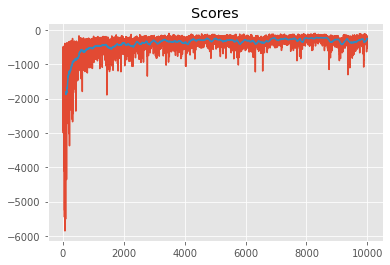

In [70]:
def plot_scores(scores, rolling_window=100):
    """Plot scores and optional rolling mean using specified window."""
    plt.plot(scores); plt.title("Scores");
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean);
    return rolling_mean

rolling_mean = plot_scores(scores)

In [71]:
with open('g55.pickle', 'wb') as handle:
    pickle.dump(scores, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [72]:
# with open('fl.pickle', 'rb') as handle:
#     object_file = pickle.load(handle)
# print(object_file)

g25.pickle
g50.pickle
g75.pickle


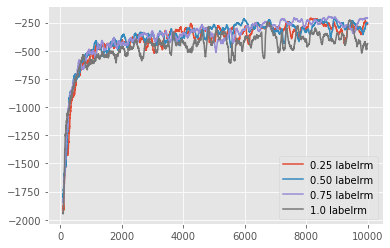

In [89]:
def plot_scores( rolling_window=100):
    """Plot scores and optional rolling mean using specified window."""
#     plt.plot(score75,label="75label"); plt.title("Scores");

#     plt.plot(score9,label="9label"); 
    for i in range(25,100,25):
        x = 'g'+str(i)+'.pickle'
        print(x)
        with open(x, 'rb') as handle:
            score = pickle.load(handle)
        rolling_mean9 = pd.Series(score).rolling(rolling_window).mean()
        plt.plot(rolling_mean9,label="0."+str(i)+" labelrm");
#     rolling_mean99 = pd.Series(score99).rolling(rolling_window).mean()
#     plt.plot(rolling_mean99,label="99labelrm");
#     rolling_mean999 = pd.Series(score999).rolling(rolling_window).mean()
#     plt.plot(rolling_mean999,label="999labelrm");
    with open('g100.pickle', 'rb') as handle:
        score05 = pickle.load(handle)
    rolling_mean = pd.Series(score05).rolling(rolling_window).mean()
    plt.plot(rolling_mean,label="1.0 labelrm");
    plt.legend()
    plt.savefig('plot3.png')
    return rolling_mean
rolling_mean = plot_scores()